In [1]:
import fedhex as fx
from matplotlib import pyplot as plt
import numpy as np

In [2]:
root_path = "./root/10x10box_10k_jun2023/"
rl = fx.RootLoader(path=root_path)

In [3]:
thresh = 150
samples, labels = rl.load(event_thresh=thresh)

16:20:05.66 <W> --- ./root/10x10box_10k_jun2023//Phi_1870_omega_9p025/2023-06-
12-11-54-06/v1p0-78-8cf4/ATTOAODv1p2c2_0.root: empty file ---


In [4]:
data, cond = rl.preproc()

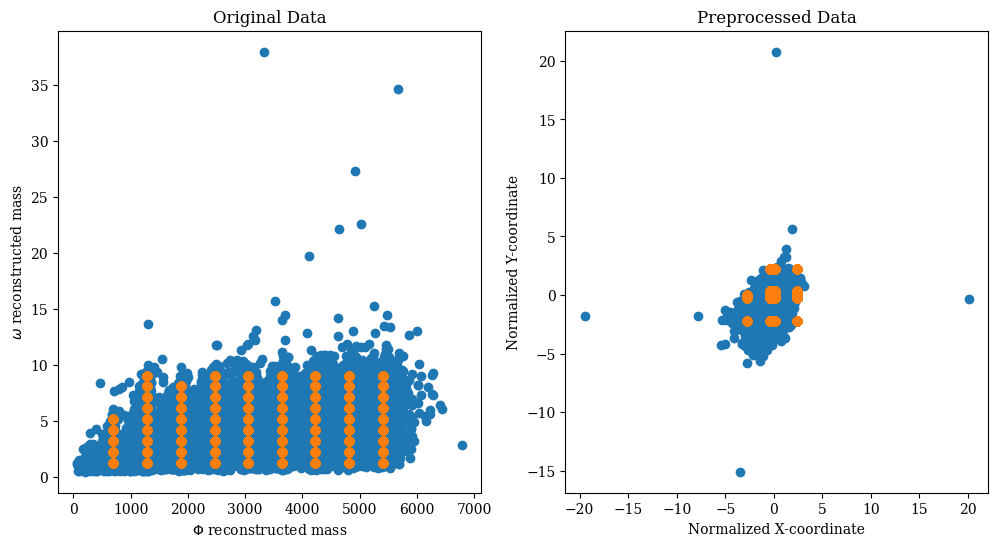

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

ax1.scatter(samples[:,0], samples[:,1])
ax1.scatter(labels[:,0], labels[:,1])
ax1.set_title("Original Data")
ax1.set_xlabel(r"$\Phi$ reconstructed mass")
ax1.set_ylabel(r"$\omega$ reconstructed mass")

ax2.scatter(data[:,0], data[:,1])
ax2.scatter(cond[:,0], cond[:,1])
ax2.set_title("Preprocessed Data")
ax2.set_xlabel("Normalized X-coordinate")
ax2.set_ylabel("Normalized Y-coordinate")
pass

In [6]:
nmade = 10
ninputs = 2
ncinputs = 2
hidden_layers = 1
hidden_units = 128
lr_tuple = (1e-3, 1e-4, 100)
mm = fx.MADEManager(nmade=nmade, ninputs=ninputs, ncinputs=ncinputs,
                    hidden_layers=hidden_layers, hidden_units=hidden_units,
                    lr_tuple=lr_tuple)

In [7]:
mm.compile_model()

In [8]:
starting_epoch = 0
end_epoch = 200
batch_size = 1024
flow_path = "./model/08-24_tut_root/"
loss_path = flow_path + "loss.npy"

In [9]:
from fedhex.train import Checkpointer, EpochLossHistory, SelectiveProgbarLogger

callbacks = []

save_freq = 50 * batch_size
callbacks.append(Checkpointer(filepath=flow_path, save_freq=save_freq))

callbacks.append(EpochLossHistory(loss_path=loss_path))

log_freq = 10
callbacks.append(SelectiveProgbarLogger(1, epoch_interval=log_freq, epoch_end=end_epoch))

In [10]:
mm.train_model(data=data, cond=cond, batch_size=batch_size,
               starting_epoch=starting_epoch, end_epoch=end_epoch,
               path=flow_path, callbacks=callbacks)

16:20:13.62 <I> [Training begins]


2023-09-15 16:20:13.667500: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


epoch begin: 2023-09-15 16:20:28.511783 | time elapsed: 0:00:14.845909
Epoch 10/200
47/47 [==============================] - 1s 30ms/sample - loss: 2.9683
epoch begin: 2023-09-15 16:20:41.159076 | time elapsed: 0:00:27.493202
Epoch 20/200
47/47 [==============================] - 1s 25ms/sample - loss: 2.0267
epoch begin: 2023-09-15 16:20:52.801807 | time elapsed: 0:00:39.135933
Epoch 30/200
47/47 [==============================] - 1s 25ms/sample - loss: 1.5652
epoch begin: 2023-09-15 16:21:04.498447 | time elapsed: 0:00:50.832573
Epoch 40/200
47/47 [==============================] - 1s 24ms/sample - loss: 1.1972
epoch begin: 2023-09-15 16:21:16.627980 | time elapsed: 0:01:02.962106
Epoch 50/200
47/47 [==============================] - 1s 29ms/sample - loss: 0.9743
epoch begin: 2023-09-15 16:21:28.388081 | time elapsed: 0:01:14.722207
Epoch 60/200
47/47 [==============================] - 1s 26ms/sample - loss: 0.7499
epoch begin: 2023-09-15 16:21:40.057201 | time elapsed: 0:01:26.391327

INFO:tensorflow:Assets written to: ./model/08-24_tut_root/assets


INFO:tensorflow:Assets written to: ./model/08-24_tut_root/assets


16:24:07.27 <I> [Training ends]
0:03:53.65 <I> [Time elapsed]


In [11]:
ngen = 500
gen_labels_unique = [2464., 5.125]
gen_labels = np.repeat([gen_labels_unique], ngen, axis=0)
gen_cond = rl.norm(gen_labels, is_cond=True)

In [12]:
gen_data = mm.eval_model(gen_cond)

In [13]:
gen_samples = rl.denorm(gen_data, is_cond=False)

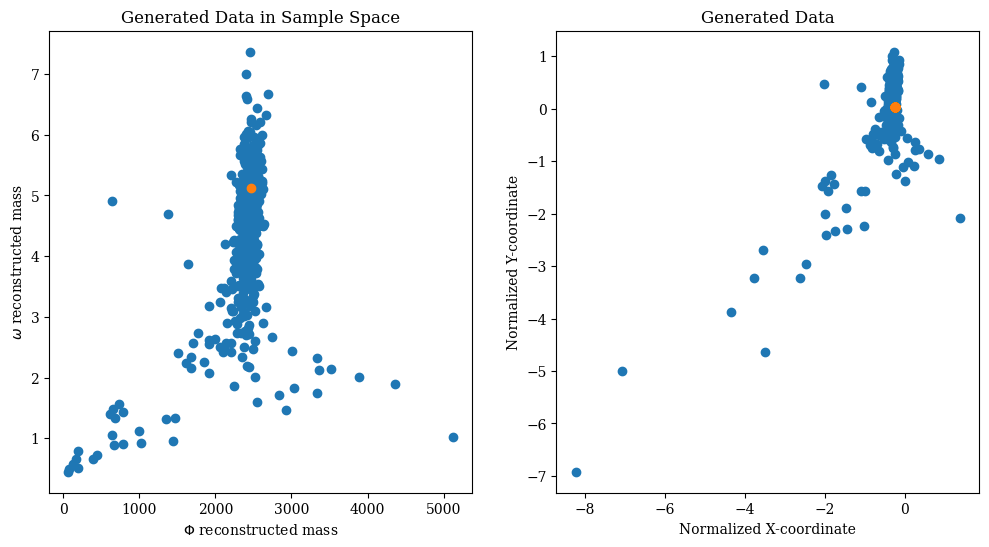

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

ax1.scatter(gen_samples[:,0], gen_samples[:,1])
ax1.scatter(gen_labels_unique[0], gen_labels_unique[1])
ax1.set_title("Generated Data in Sample Space")
ax1.set_xlabel(r"$\Phi$ reconstructed mass")
ax1.set_ylabel(r"$\omega$ reconstructed mass")

ax2.scatter(gen_data[:,0], gen_data[:,1])
ax2.scatter(gen_cond[:,0], gen_cond[:,1])
ax2.set_title("Generated Data")
ax2.set_xlabel("Normalized X-coordinate")
ax2.set_ylabel("Normalized Y-coordinate")
pass

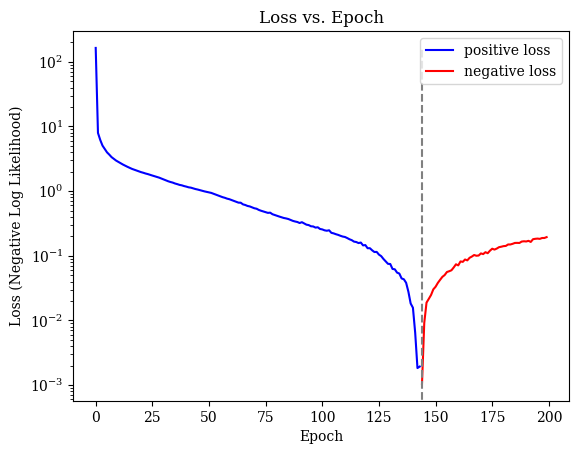

In [15]:
from fedhex.posttrain import plot as fxp
fxp.plot_losses(np.load(loss_path), show=True)

In [16]:
#Save output to a ROOT or npy file. Training data ("trn_data", "trn_cond") is optional
output_path = "./output/09-15-tut_root/" 
npy_path = output_path + "npy/npy_out.npy"
root_out_path = output_path + "root/root_out.ROOT"
custom_root_path = output_path + "root/custom_root_out.ROOT"
#All directories above must already exist

saver = fx.Loader(data_dict={"gen_samples": gen_samples, "gen_labels": gen_labels, "trn_samples": samples, "trn_labels": labels})

saver.save_to_root(root_out_path, custom=False) #Requires above dictionary format

fx.Loader(data_dict = 
          {"Gen_Phi": gen_samples[:,0], "Gen_Omega" : gen_samples[:,1], "Gen_Phi_Labels":gen_labels[:,0], "Gen_Omega_Labels":gen_labels[:,1]}
          ).save_to_root(custom_root_path, custom=True) #Default mode, dictionary can be of any format as long as all values are of equal length

saver.save_to_npy(npy_path)